# 1: Import Libraries and Download the Dataset

In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly

     |████████████████████████████████| 3.7MB 11.6MB/s 


In [ ]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

###  Download the Oxford-IIIT Pets dataset

However, suppose we want to know the location of an object in the image, the shape of that object, which pixel belongs to which object, etc. <br/>
In this case you will want to segment the image, i.e., each pixel of the image is given a label. Thus, the task of image segmentation is to train a neural network to output a pixel-wise mask of the image. This helps in understanding the image at a much lower level, i.e., the pixel level. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging to name a few. 

**Overview of the data set:** <br/>
The dataset that will be used for this poject is the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), created by Parkhi *et al*. The dataset consists of images, their corresponding labels, and pixel-wise masks. The masks are basically labels for each pixel. Each pixel is given one of three categories :

*   Class 1 : Pixel belonging to the pet.
*   Class 2 : Pixel bordering the pet.
*   Class 3 : None of the above/ Surrounding pixel.

The dataset is already included in TensorFlow datasets, all that is needed to do is download it ⏬.<br/>
(The segmentation masks are included in version 3+)

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete8EK69A/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete8EK69A/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

In [5]:
dataset

{'test': <PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>,
 'train': <PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>}

# 2: Preprocess Data and View Segmentation Mask

### Preprocess the Data

The following code performs a simple augmentation of flipping an image. <br/>
* In addition, image is normalized to [0,1].<br/>
* Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}. <br/>
For the sake of convenience, let's subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.

In [6]:
def normalize(image, mask):
  image = tf.cast(image, tf.float32)/255.
  mask -=1
  return image, mask

@tf.function
def load_image_train(data):
  image = tf.image.resize(data['image'], (128,128))
  mask = tf.image.resize(data['segmentation_mask'], (128,128))

  if tf.random.uniform(()) > 0.5:
    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)
  
  image, mask = normalize(image, mask)
  return image, mask

def load_image_test(data):
  image = tf.image.resize(data['image'], (128,128))
  mask = tf.image.resize(data['segmentation_mask'], (128,128))

  image, mask = normalize(image, mask)
  return image, mask

In [7]:
#training and testing length
info.splits['train'].num_examples, info.splits['test'].num_examples

(3680, 3669)

In [8]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH / BATCH_SIZE

In [9]:
#The dataset already contains the required splits of test and train, so let's continue to use the same split

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [10]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

### Data Vizulization

In [11]:
def display(display_list):
  plt.figure(figsize=(15,15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

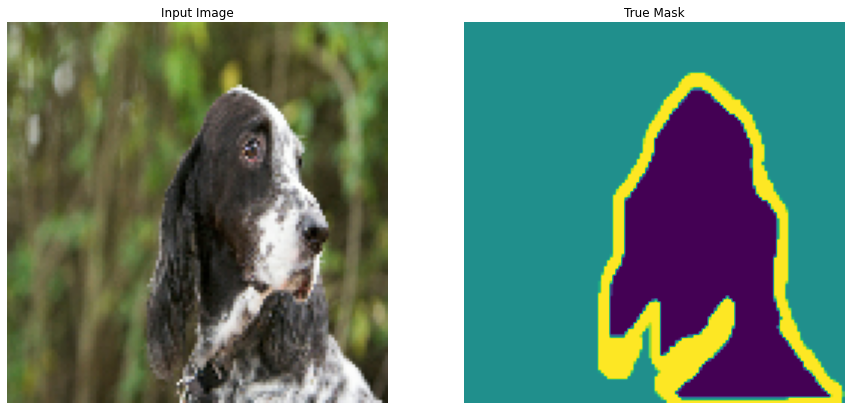

In [19]:
for image, mask in train.take(50):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

# 3: Define the model
The model being used here is a modified U-Net.<br/>
⚠ A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder. Thus, the encoder for this task will be a pretrained MobileNetV2 model, whose intermediate outputs will be used.<br/> 

⚠ The reason to output three channels is because there are three possible labels for each pixel.

In [39]:
# loading pre trained model
base_model = tf.keras.applications.MobileNetV2(input_shape=(128,128,3), include_top=False)

names = ['block_1_expand_relu', 'block_3_expand_relu', 'block_6_expand_relu',
         'block_13_expand_relu', 'block_16_expand_relu']
layers = [base_model.get_layer(name).output for name in names]

down_sample = tf.keras.Model(base_model.input, layers)
down_sample.trainable = False

In [40]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [41]:
inputs = tf.keras.layers.Input(shape=[128,128,3 ])
x = inputs

# Downsampling through the model
skips = down_sample(x)
x = skips[-1]
skips = reversed(skips[:-1])

# Upsampling and establishing the skip connections
for up, skip in zip(up_stack, skips):
  x = up(x)
  concat = tf.keras.layers.Concatenate()
  x = concat([x, skip])

# This is the last layer of the model
x = tf.keras.layers.Conv2DTranspose(3, 3, strides=2 , padding='same')(x)  #64x64 -> 128x128

model = tf.keras.Model(inputs, x)

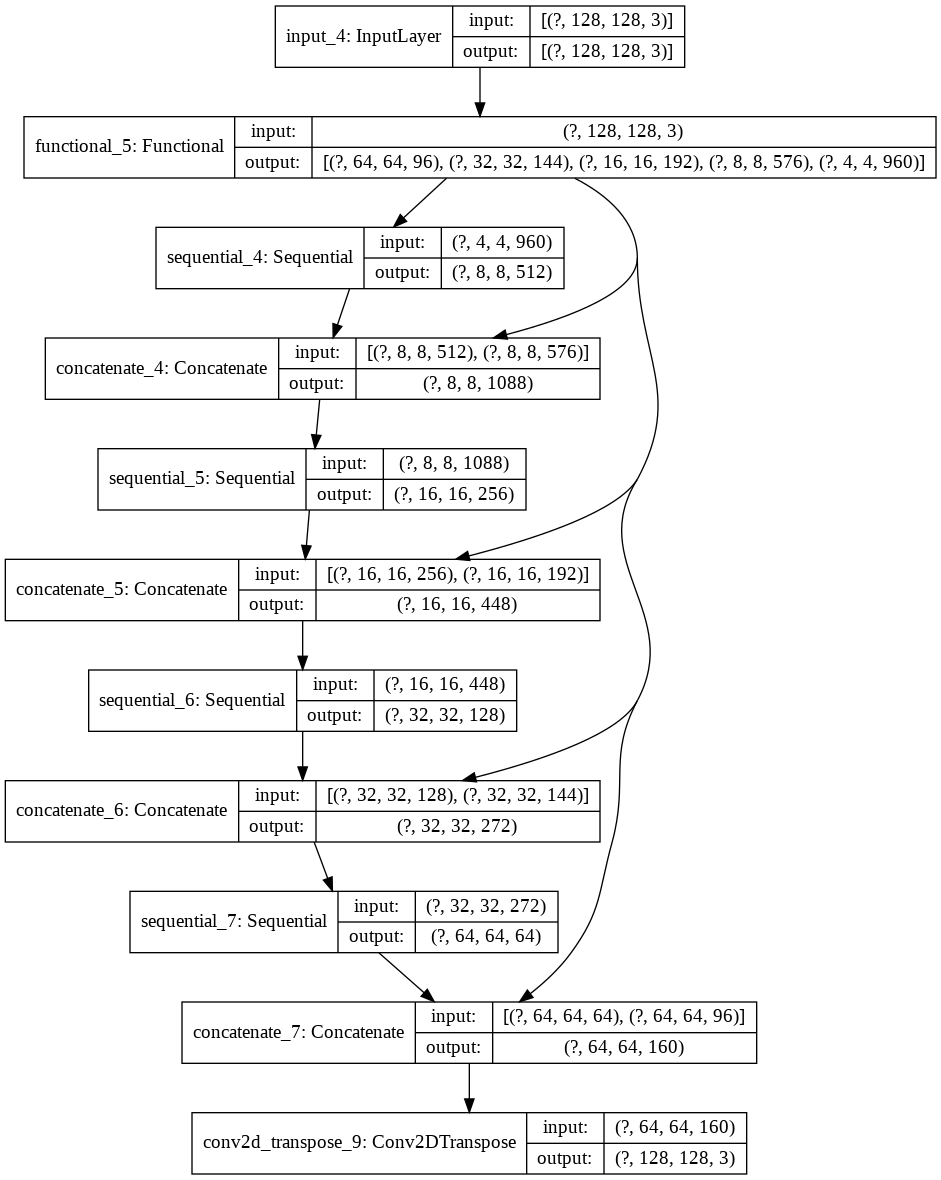

In [42]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
             )
tf.keras.utils.plot_model(model, show_shapes=True)

# 4: Train the model and Visualize Result

In [43]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

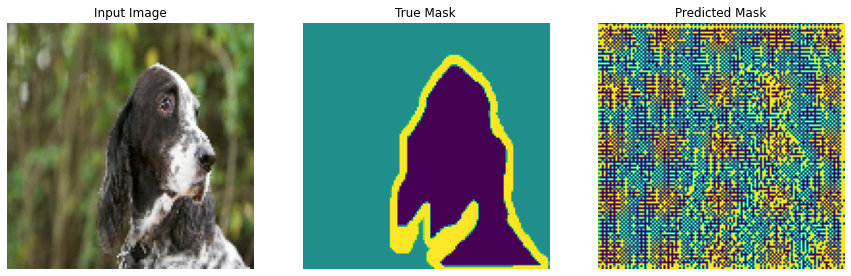

In [44]:
show_predictions()

In [45]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

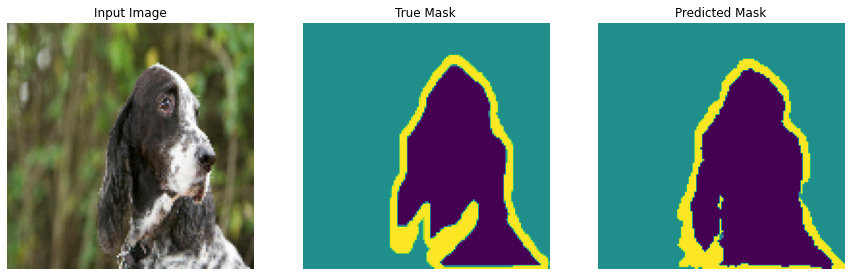


Sample Prediction after epoch 50

58/57 [==============================] - 19s 320ms/step - loss: 0.0472 - accuracy: 0.9715 - val_loss: 0.6201 - val_accuracy: 0.8835


In [46]:
EPOCHS =  50

h = model.fit(train_dataset, 
              epochs=EPOCHS,
              steps_per_epoch=STEPS_PER_EPOCH,
              validation_data=test_dataset,
              callbacks=[DisplayCallback()])

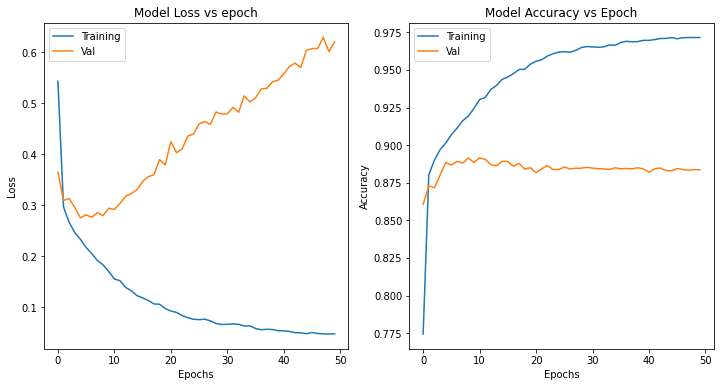

In [49]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(h.history['loss'], label='Training')
plt.plot(h.history['val_loss'], label='Val')
plt.title('Model Loss vs epoch')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.subplot(1,2,2)
plt.plot(h.history['accuracy'], label='Training')
plt.plot(h.history['val_accuracy'], label='Val')
plt.title('Model Accuracy vs Epoch')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

# 5: VIZULAZING RESULTS

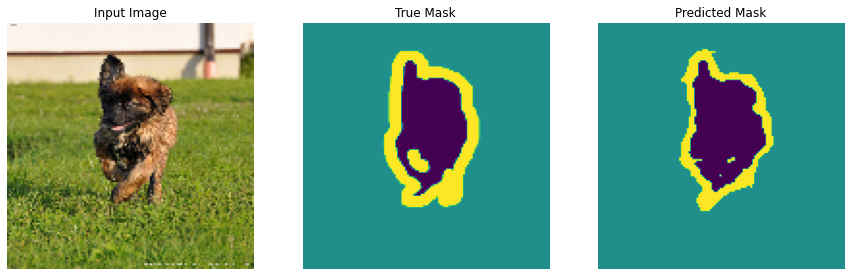

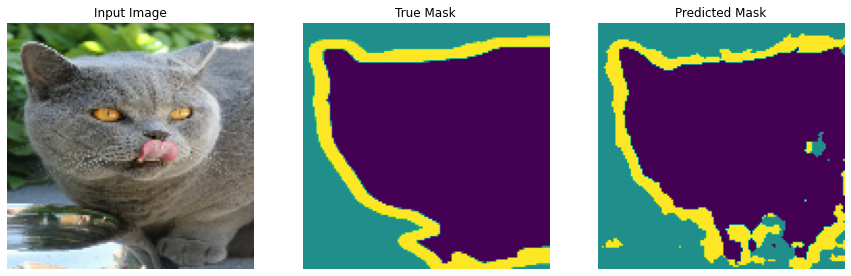

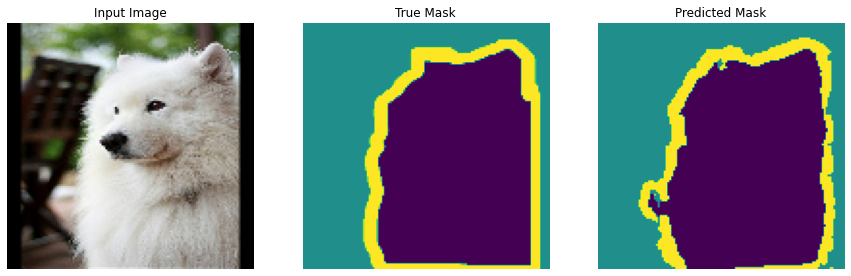

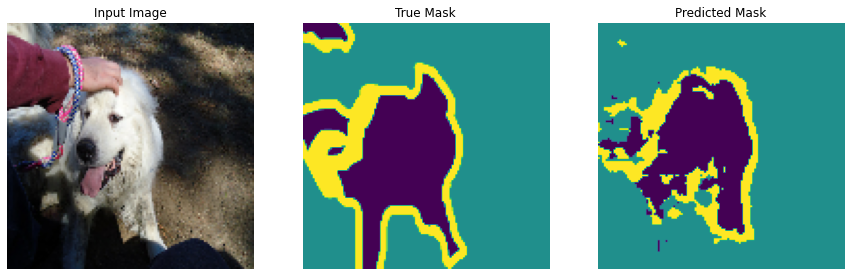

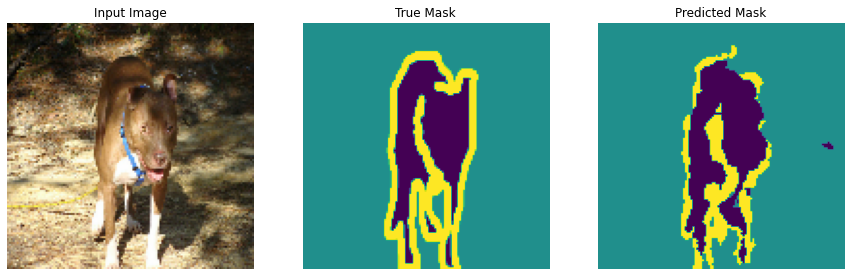

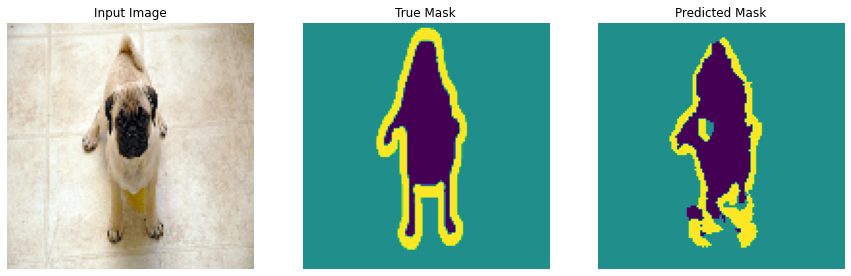

In [47]:
show_predictions(test_dataset, 6)